# Lego City - Train Model for Multi-Task Learning

We will be using Torch frameowrk for multi-task training the model with gathered dataset. Here we consider folliwng tasks:
1. Road Following - 3 Classes  namely Move Forward, Move Right, and Move Left
2. Intersection Detection- Binary Class - Intersection / No Intersection
3. Collison Detection - Binary Class - Collision / No Collision

More about Multi-task learning can be found in this quick video: https://www.youtube.com/watch?v=UdXfsAr4Gjw

In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np

### Upload and extract dataset

In [ ]:
!mkdir dataset && cd dataset

Download the dataset gathered using Jetbot. We can use well-know tool to copy over server SCP.

Example:
scp jetbot@JETBOT_IP_ADDRESS:DIR_NAME/dataset_fwd_intersections.tar.gz .
scp jetbot@JETBOT_IP_ADDRESS:DIR_NAME/dataset_collision_detection.tar.gz .
scp jetbot@JETBOT_IP_ADDRESS:DIR_NAME/dataset_intersection_detection.tar.gz .

In [2]:
!tar -xf dataset_fwd_intersections.tar.gz
!tar -xf dataset_crosswalk_detection.tar.gz
!tar -xf dataset_right_intersections.tar.gz
!tar -xf dataset_stop_intersections.tar.gz

You should see a folder named ``dataset`` appear in the file browser.

### Create model

We will use pre-trained ResNet18 model to perform transfer learning. 
More about ResNet Architecture can be found here: https://arxiv.org/abs/1512.03385

We will have 7 classes as mentioned above

In [4]:
num_classes = 7 

In [5]:
device = torch.device('cuda')
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

### Create data loaders

Now we use the ``ImageFolder`` dataset class available with the ``torchvision.datasets`` package.  We attach transforms from the ``torchvision.transforms`` package to prepare the data for training.  

In [6]:
class TurnDataset(datasets.ImageFolder):
    
    def __init__(self, directory, flipped=False):
        
        self.flipped = flipped
        
        transforms_list = []
        
        transforms_list += [
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
        
        datasets.ImageFolder.__init__(self, directory, transforms.Compose(transforms_list))
        
        
    def __getitem__(self, index):
        image, label = datasets.ImageFolder.__getitem__(self, index)
        image = image.numpy()
        target = np.zeros(3, dtype=np.float32)
        
        # mirror image and flip left/right label
        if self.flipped:
            image = image[:, :, ::-1]
            if label == 1:
                label = 2
            elif label == 2:
                label = 1
            
        if label == 0:
            target = np.array([0.2, 1.0, 0.2], dtype=np.float32)  # forward
        elif label == 1:
            target = np.array([1.0, 0.2, 0.0], dtype=np.float32)  # left
        else:
            target = np.array([0.0, 0.2, 1.0], dtype=np.float32)  # right
            
        return torch.from_numpy(image.copy()), label, torch.from_numpy(target.copy())

        
fwd_dataset = TurnDataset('data/data_googledrive/dataset_fwd_intersections')

In [7]:
class BinaryDataset(datasets.ImageFolder):
    
    def __init__(self, directory, random_image_flips=False):
        
        transforms_list = []
        
        if random_image_flips:
            transforms_list += [transforms.RandomHorizontalFlip()]
            
        transforms_list += [
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
        
        datasets.ImageFolder.__init__(self, directory, transforms.Compose(transforms_list))
    
    def __getitem__(self, index):
        image, label = datasets.ImageFolder.__getitem__(self, index)
        return image, label

collision_dataset = BinaryDataset('data/data_googledrive/dataset_lego_colavoid', random_image_flips=True)
crosswalk_dataset = BinaryDataset('data/data_googledrive/dataset_stop_intersections', random_image_flips=True)

## Create data loaders

In [8]:
BATCH_SIZE = 64

fwd_loader = torch.utils.data.DataLoader(fwd_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
collision_loader = torch.utils.data.DataLoader(collision_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
crosswalk_loader = torch.utils.data.DataLoader(crosswalk_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
NUM_EPOCHS = 60
BEST_MODEL_PATH = 'best_model_adam.pth'
best_case_loss = 100000

model.train()

for i in range(NUM_EPOCHS):
    
    fwd_iter = iter(fwd_loader)
    collision_iter = iter(collision_loader)
    crosswalk_iter = iter(crosswalk_loader)
    
    print('EPOCH %d' % i)
    
    while True: 
        try:
            fwd_images, fwd_labels, fwd_targets = next(fwd_iter)
            collision_images, collision_labels = next(collision_iter)
            crosswalk_images, crosswalk_labels = next(crosswalk_iter)
        except StopIteration:
            break  # this will exit the while loop if any of the iterators have finished
        
        optimizer.zero_grad()
        
        # compute road following loss
        fwd_images = fwd_images.to(device)
        fwd_targets = fwd_targets.to(device)
        fwd_labels = fwd_labels.to(device)
        fwd_outputs = model(fwd_images)[:, 0:3]
        fwd_loss = F.mse_loss(fwd_outputs, fwd_targets)
        
        # compute collision loss
        collision_images = collision_images.to(device)
        collision_labels = collision_labels.to(device)
        collision_outputs = model(collision_images)[:, 3:5]
        collision_loss = F.cross_entropy(collision_outputs, collision_labels)
        
        # compute crosswalk loss
        crosswalk_images = crosswalk_images.to(device)
        crosswalk_labels = crosswalk_labels.to(device)
        crosswalk_outputs = model(crosswalk_images)[:, 5:7]
        crosswalk_loss = F.cross_entropy(crosswalk_outputs, crosswalk_labels)
        
        # Compute Total Loss
        total_loss = 5.0 * fwd_loss + 1.0 * collision_loss + 1.0 * crosswalk_loss


        total_loss.backward()
        optimizer.step()
        if total_loss < best_case_loss:
            best_case_loss = total_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print('TOTAL: %f, F: %f,, C: %f, CW: %f' % (total_loss, fwd_loss, collision_loss, crosswalk_loss))
        

EPOCH 0
TOTAL: 3.308018, F: 0.390602,, C: 0.697932, CW: 0.657076
Best Case Loss: 3.308018
Best Case Loss: 2.942436
Best Case Loss: 2.510220
Best Case Loss: 2.003645
Best Case Loss: 1.912272
Best Case Loss: 1.698908
Best Case Loss: 1.440932
Best Case Loss: 1.359648
Best Case Loss: 1.351511
Best Case Loss: 1.214359
Best Case Loss: 1.181880
Best Case Loss: 1.022359
Best Case Loss: 1.006904
Best Case Loss: 0.999722
Best Case Loss: 0.825534
TOTAL: 1.064251, F: 0.113712,, C: 0.328163, CW: 0.167528
Best Case Loss: 0.709330
Best Case Loss: 0.638949
Best Case Loss: 0.628170
Best Case Loss: 0.562988
EPOCH 1
Best Case Loss: 0.522294
Best Case Loss: 0.459184
Best Case Loss: 0.438109
TOTAL: 0.459300, F: 0.046000,, C: 0.168569, CW: 0.060731
Best Case Loss: 0.408545
Best Case Loss: 0.316996
Best Case Loss: 0.313047
TOTAL: 0.338342, F: 0.039681,, C: 0.124430, CW: 0.015506
EPOCH 2
Best Case Loss: 0.272473
Best Case Loss: 0.253775
Best Case Loss: 0.193422
TOTAL: 0.214805, F: 0.024602,, C: 0.082644, CW: 

## Check Performance of Trained Model 

Once we complete Training the mulit-task learning, we can check accuracy performance on one of the image newly gathered or from previously gathered dataset.

In [12]:
import matplotlib.pyplot as plt

In [13]:
model.load_state_dict(torch.load('best_model_adam.pth'))
model = model.eval()

Output labels can be understood as follows:
1. Road Follower : fwd_dataset.class_to_idx
2. Collision Detection: collision_dataset.class_to_idx
3. Crosswalk Detection: crosswalk_dataset.class_to_idx

In [14]:
output_labels = [ fwd_dataset.class_to_idx, collision_dataset.class_to_idx, crosswalk_dataset.class_to_idx]
print (output_labels)

[{'move_left': 1, 'move_right': 2, 'move_fwd': 0}, {'free': 1, 'blocked': 0}, {'intersection': 0, 'no_intersection': 1}]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 0.8540,  0.2976,  0.1453,  5.4474, -5.9082, -2.5940,  3.0200]],
       device='cuda:0', grad_fn=<AddmmBackward>)
0


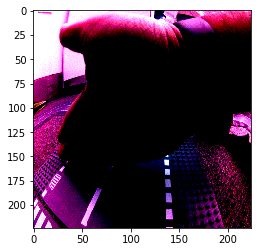

In [16]:
image, label = collision_dataset[90]

output = model(image.to(device)[None, ...])


image = image.cpu().numpy().transpose(1, 2, 0)

plt.imshow(image)

print(output)
print(label)

## Copy Trained Model to JetBot

If the visual performance is good, copy "BEST_MODEL_PATH = 'best_model_adam.pth'" to JetBot

Example:
scp best_model_adam.pth jetbot@JETBOT_IP_ADDRESS:DIR_NAME